In [1]:
!pip install --upgrade scikit-learn --no-index --find-links=file:///kaggle/input/scikit-learn-1-4-0/ 

Looking in links: file:///kaggle/input/scikit-learn-1-4-0/


In [2]:
import os, glob, shutil
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from pathlib import Path
from typing import Literal, List
from tqdm.auto import tqdm
import polars as pl
import polars.selectors as cs

from sklearn.model_selection import train_test_split, cross_validate, StratifiedGroupKFold, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from mlxtend.evaluate import GroupTimeSeriesSplit

import lightgbm as lgb

import joblib

In [3]:
TRAIN = True
VALIDATE = True

In [4]:
if os.path.exists('/kaggle'):
    PATH_DATASET = Path("/kaggle/input/home-credit-credit-risk-model-stability")
    if TRAIN:
        MODELS_PATH = Path("/kaggle/working/models")
    else:
        MODELS_PATH = Path("/kaggle/input/home_credit/scikitlearn/home_credit/17")
else:
    PATH_DATASET = Path("home-credit-credit-risk-model-stability")
    MODELS_PATH = Path("models")
    if os.path.exists(MODELS_PATH):
        shutil.rmtree(MODELS_PATH)
    os.makedirs(MODELS_PATH)
    
PATH_PARQUETS = PATH_DATASET / "parquet_files"
PATH_TRAIN = PATH_PARQUETS / "train"
PATH_TEST = PATH_PARQUETS / "test"

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Load data

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # else:
        #     df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
class DatasetConstructor:
    def __init__(self, subsciption: list):
        self.subsciption = subsciption
        self.schemes = {}
        self.drop_cols = []
                        
    def _to_pandas(self, df):
        df = df.to_pandas().set_index('case_id')
        df = df.replace([np.inf, -np.inf, None], np.nan)
        return df
        
    def _aggregate(self, df, name):
        index_cols = [col for col in ['num_group1', 'num_group2'] if col in df.columns]
        aggs = [
            pl.len().alias(f'{name.replace("*", "")}_len'),
            pl.col(pl.NUMERIC_DTYPES).min().name.suffix('_min'),
            pl.col(pl.NUMERIC_DTYPES).mean().name.suffix('_mean'),
            pl.col(pl.NUMERIC_DTYPES).max().name.suffix('_max'),
            pl.col(pl.NUMERIC_DTYPES).std().name.suffix('_std'),
            pl.col(pl.NUMERIC_DTYPES).first().name.suffix('_last'),

            pl.col(pl.Categorical).mode().max().name.suffix('_mode'),
            pl.col(pl.Categorical).n_unique().name.suffix('_nunique'),
            pl.col(pl.Categorical).first().name.suffix('_last'),
            
            pl.col(pl.Date).max(),
        ]

        df = (
            df
            .sort(['case_id'] + index_cols)
            .drop(index_cols)
            .group_by('case_id').agg(*aggs)
        )

        return df

    def join(self, path, df_base):
        name = path.stem.split('_', 1)[1]
        print(name)
        df = pl.concat(
             [
                 pl.scan_parquet(p, low_memory=True) 
                 for p in glob.glob(str(path))
             ], how="vertical_relaxed"
        )
        
        if name not in self.schemes:
            df = df.with_columns(
                cs.ends_with('D').cast(pl.String).str.to_date(strict=False),
                cs.ends_with('M').cast(pl.String).cast(pl.Categorical),
                pl.col('case_id').cast(pl.Int64),
            )
            
            df = df.with_columns(
                cs.by_dtype(pl.String).cast(pl.Categorical),
                cs.by_dtype(pl.Boolean).cast(pl.UInt8)
            )
            self.schemes[name] = df.schema
        else:
            df = df.with_columns(pl.col(c).cast(dtype) for c, dtype in self.schemes[name].items())
            
        # Aggregate depth 1 and 2 data
        if '0' not in name:
            df = self._aggregate(df, name)

        # True if case_id is in dataframe
        df = df.with_columns(
            pl.col('case_id').is_not_null().alias(f'is_in_{name.replace("*", "")}').cast(pl.Int8)
        )
        
        return df_base.join(df, how="left", on="case_id")

    def get_drop_list(self, df):
        drop_cols = []
        for col in df.columns:
            if df[col].is_null().mean() > 0.98:
                drop_cols.append(col)
        
        for col in df.select(cs.by_dtype(pl.Categorical)).columns:
            if df[col].n_unique() > 200:
                drop_cols.append(col)
        return drop_cols
    
    def load(self, mode: Literal['train', 'test']):
        path = PATH_PARQUETS / mode
        df = pl.scan_parquet(path / f"{mode}_base.parquet", low_memory=True).with_columns(
            pl.col("date_decision").str.to_date()
        )
        for stem in self.subsciption:
            df = self.join(path / f"{mode}_{stem}.parquet", df)

        # NaN for is_in_{file} column means that it was not there
        df = df.with_columns(
            cs.starts_with('is_in_').fill_null(0)
        )
            
        df = df.with_columns(
            (pl.col(col) - pl.col('date_decision')).dt.total_days()
            for col in df.columns if col.endswith('D')
        )

        df = df.with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
            pl.col(pl.Int64).cast(pl.Int32),
        )
        
        df = df.collect()

        if mode == 'train':
            self.drop_cols = self.get_drop_list(df)
            
        df = df.drop(self.drop_cols)
            
        df = self._to_pandas(df)
        df = reduce_mem_usage(df)
            
        return df

In [7]:
info_cols = ['date_decision', 'WEEK_NUM', 'MONTH']

def generate_features(mode: Literal['train', 'test'], constructors: List[DatasetConstructor]):
    dfs = []
    for i, constructor in enumerate(constructors):
        df = constructor.load(mode)
        if i > 0:
            df = df.drop(columns=info_cols)
            if mode == 'train':
                df = df.drop(columns='target')
        dfs.append(df)
    return pd.concat(dfs, axis=1)

In [8]:
%%time
subscriptions = [
    [
        'static_0_*', 
        'static_cb_0',
    ],
    [                
        'applprev_1_*',
        'other_1',
        'tax_registry_a_1',
        'tax_registry_b_1',
        # 'tax_registry_c_1',
        
        # 'credit_bureau_b_1',
        # 'deposit_1',
        # 'person_1',
        # 'debitcard_1',
    ],
    # ['credit_bureau_a_1_*',],
    # [
    #     'applprev_2',
    #     'person_2',
    #     'credit_bureau_b_2',
    # ],
    # ['credit_bureau_a_2_*',]
]
constructors = [DatasetConstructor(subs) for subs in subscriptions]
df_train = generate_features('train', constructors)

static_0_*
static_cb_0
Memory usage of dataframe is 1303.08 MB
Memory usage after optimization is: 703.23 MB
Decreased by 46.0%
applprev_1_*
other_1
tax_registry_a_1
tax_registry_b_1
Memory usage of dataframe is 1190.96 MB
Memory usage after optimization is: 765.83 MB
Decreased by 35.7%
CPU times: user 1min 57s, sys: 36.3 s, total: 2min 33s
Wall time: 15.6 s


In [9]:
df_train = df_train.reset_index().sort_values(['WEEK_NUM', 'case_id']).set_index('case_id')
X, y = df_train.drop(columns=info_cols + ['target']), df_train['target']

features = X.columns.tolist()

X.shape

(1526659, 387)

# Train model

In [10]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5, verbose=False):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    

    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    if verbose:
        print(f'{avg_gini=:.3f} {a=:.3f} {res_std=:.3f}')
        plt.plot(np.arange(len(gini_in_time)), gini_in_time)
        plt.title('Gini by week')
        plt.show()
        plt.close()
    
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [11]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 4,
    "num_leaves": 16,
    "min_data_in_leaf": 20,
    "learning_rate": 0.03,
    "feature_fraction": 0.2,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 600,
    'min_data_in_bin': 5,
    'max_bin': 32,
    "verbose": -1,
    'n_jobs': -1
}

In [12]:
df_train['date_decision'].agg(['min', 'max'])

min   2019-01-01
max   2020-10-05
Name: date_decision, dtype: datetime64[ns]

In [13]:
df_train['WEEK_NUM'].nunique()

92

In [14]:
fold_size = int(df_train['WEEK_NUM'].nunique() / 4)
cv = GroupTimeSeriesSplit(test_size=fold_size, train_size=fold_size, shift_size=fold_size)
# cv = StratifiedGroupKFold(5, shuffle=False)
for train_idx, val_idx in cv.split(X, y, df_train['WEEK_NUM']):
    print(df_train['WEEK_NUM'].iloc[train_idx].unique(), df_train['WEEK_NUM'].iloc[val_idx].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] [46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
[46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68] [69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]


In [15]:
class ForwardFeatureSelector:
    def __init__(self):
        pass

    def fit(self, X, y, groups):
        selected_features = pd.Series()
        try:
            while True:
                if len(selected_features) == len(X.columns):
                    break
                current_scores = pd.Series()
                for feature in tqdm(X.columns):
                    if feature in selected_features.index:
                        continue
                    X_subset = X[selected_features.index.tolist() + [feature]]
                    cv_results = cross_validate(
                        lgb.LGBMClassifier(**params, random_state=42), 
                        X_subset, y, 
                        groups=groups, 
                        scoring='roc_auc', 
                        cv=cv,
                        verbose=0, 
                        return_estimator=True, 
                        return_indices=True
                    )
                    
                    stability_results = []
                    for fold, (idx, model) in enumerate(zip(cv_results['indices']['test'], cv_results['estimator'])):
                        df_res = pd.DataFrame()
                        
                        df_res['WEEK_NUM'] = groups.iloc[idx].values
                        df_res['target'] = y.iloc[idx].values
                        df_res['score'] = model.predict_proba(X_subset.iloc[idx])[:, 1]
                        df_res['fold'] = fold
                        stability_results.append(df_res)
                    df_stability_results = pd.concat(stability_results)
    
                    current_scores[feature] = df_stability_results.groupby('fold').apply(gini_stability, include_groups=False).mean()
                if current_scores.max() <= selected_features.max():
                    break
                selected_features[current_scores.index[current_scores.argmax()]] = current_scores.values[current_scores.argmax()]
                print(current_scores.index[selected_features.argmax()], current_scores.max())
        except KeyboardInterrupt:
            return selected_features
        return selected_features

In [16]:
# selector = ForwardFeatureSelector()
# selected_features = selector.fit(X, y, df_train['WEEK_NUM'])
# selected_features.to_csv('selected_features.csv')
# selected_features

In [17]:
# selected_features = pd.read_csv('selected_features.csv', index_col=0).squeeze()
# features = selected_features.index.tolist()
# features

In [18]:
# X = X[features]

[CV] END ......................................., score=0.802 total time=   9.7s
[CV] END ......................................., score=0.808 total time=  12.8s
[CV] END ......................................., score=0.824 total time=  10.7s
AUC: 0.811 +-0.009


fold
0    0.361242
1    0.467134
2    0.615264
dtype: float64

Mean Gini stability: 0.4812


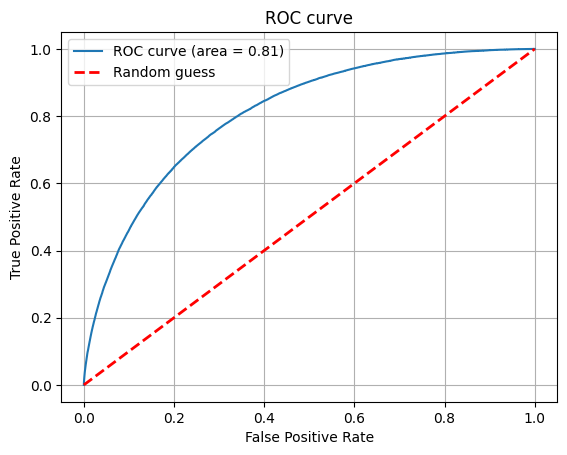

CPU times: user 14min 48s, sys: 2.33 s, total: 14min 50s
Wall time: 37.4 s


In [19]:
%%time

if VALIDATE:
    cv_results = cross_validate(
        lgb.LGBMClassifier(**params, random_state=42), 
        X, y, 
        groups=df_train['WEEK_NUM'], 
        scoring='roc_auc', 
        cv=cv,
        verbose=3, 
        return_estimator=True, 
        return_indices=True
    )
    print(f"AUC: {cv_results['test_score'].mean():.3f}", f"+-{cv_results['test_score'].std():.3f}")
    
    stability_results = []
    for fold, (idx, model) in enumerate(zip(cv_results['indices']['test'], cv_results['estimator'])):
        df_res = pd.DataFrame()
        
        df_res['WEEK_NUM'] = df_train['WEEK_NUM'].iloc[idx].values
        df_res['target'] = df_train['target'].iloc[idx].values
        df_res['score'] = model.predict_proba(X.iloc[idx])[:, 1]
        df_res['fold'] = fold
        stability_results.append(df_res)

    df_stability_results = pd.concat(stability_results)
    
    display(df_stability_results.groupby('fold').apply(gini_stability, include_groups=False))
    print('Mean Gini stability:', f"{df_stability_results.groupby('fold').apply(gini_stability, include_groups=False).mean():.4f}")
    
    fpr, tpr, _ = roc_curve(df_stability_results['target'], df_stability_results['score'])
    
    plt.plot(
        fpr, tpr, label='ROC curve (area = %.2f)' % auc(fpr, tpr)
    )
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend()
    plt.show()

#### static_0_*
avg_gini=0.576 a=0.001 res_std=0.035

Gini stability: 0.5590

#### static_cb_0
avg_gini=0.612 a=0.001 res_std=0.040

Gini stability: 0.5921

#### applprev_1_*
avg_gini=0.624 a=0.001 res_std=0.041

Gini stability: 0.6036

#### other_1
avg_gini=0.625 a=0.001 res_std=0.041

Gini stability: 0.6039

#### tax_registry_a_1
avg_gini=0.626 a=0.001 res_std=0.041

Gini stability: 0.6057

#### tax_registry_b_1
avg_gini=0.620 a=0.000 res_std=0.039

Gini stability: 0.6010

#### tax_registry_c_1
avg_gini=0.621 a=0.000 res_std=0.040

Gini stability: 0.6006

#### credit_bureau_a_1_*
avg_gini=0.676 a=0.001 res_std=0.037

Gini stability: 0.6575

#### credit_bureau_b_1
avg_gini=0.675 a=0.000 res_std=0.038

Gini stability: 0.6564

#### deposit_1
avg_gini=0.676 a=0.001 res_std=0.035

Gini stability: 0.6579

#### person_1
avg_gini=0.684 a=0.000 res_std=0.035

Gini stability: 0.6667

#### debitcard_1
avg_gini=0.685 a=0.001 res_std=0.035

Gini stability: 0.6674

#### applprev_2
avg_gini=0.684 a=0.001 res_std=0.036

Gini stability: 0.6661

#### person_2
avg_gini=0.685 a=0.001 res_std=0.035

Gini stability: 0.6672

#### credit_bureau_a_2_*
avg_gini=0.685 a=0.001 res_std=0.036

Gini stability: 0.6669

#### credit_bureau_b_2
avg_gini=0.685 a=0.001 res_std=0.034

Gini stability: 0.6677

In [20]:
# # Save model
# if TRAIN:
#     for i, model in enumerate(cv_results['estimator']):
#         with open(MODELS_PATH / f'model_{i}.joblib', 'wb') as f:
#             joblib.dump(model, f)
#     shutil.make_archive('models', 'zip', MODELS_PATH)

In [21]:
%%time
if TRAIN:
    model = VotingClassifier(
        estimators = [(f'lgb_{i}', lgb.LGBMClassifier(**params, random_state=i)) for i in range(5)],
        voting='soft',
        verbose=3
    )
    model.fit(X, y)
    with open(MODELS_PATH / f'model.joblib', 'wb') as f:
        joblib.dump(model, f)

[Voting] .................... (1 of 5) Processing lgb_0, total=  32.4s
[Voting] .................... (2 of 5) Processing lgb_1, total=  32.6s
[Voting] .................... (3 of 5) Processing lgb_2, total=  33.1s
[Voting] .................... (4 of 5) Processing lgb_3, total=  32.0s
[Voting] .................... (5 of 5) Processing lgb_4, total=  32.9s
CPU times: user 1h 18min 3s, sys: 6.27 s, total: 1h 18min 9s
Wall time: 2min 43s


In [22]:
del df_train, X, y
gc.collect()

3782

# Loading models

In [23]:
# Read models
models = []
for model_name in os.listdir(MODELS_PATH):
    with open(MODELS_PATH / model_name, 'rb') as f:
        models.append(joblib.load(f))

# Loading test data

In [24]:
df_test = generate_features('test', constructors)

static_0_*
static_cb_0
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by -11.2%
applprev_1_*
other_1
tax_registry_a_1
tax_registry_b_1
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by -1.1%


# Predict and submit

In [25]:
test = df_test[features]

In [26]:
preds_proba = [model.predict_proba(test)[:, 1] for model in models]
df_test["score"] = np.average(preds_proba, axis=0)

In [27]:
df_test[["score"]].to_csv("submission.csv")

!head submission.csv

case_id,score
57543,0.08584944624701855
57549,0.06899882028648033
57551,0.03936078871014083
57552,0.01638209656196733
57569,0.007883316394050346
57630,0.015809200200224742
57631,0.014075430860929578
57632,0.009993359501846861
57633,0.04304990709415689
